In [2]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os

sys.path.append('/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/code')
import nibabel as nib
from dn_utils.behavioral_models import load_behavioral_data         
from nilearn import plotting, datasets
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold
from nistats.reporting import plot_design_matrix, get_clusters_table

/home/kmb/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Load statistical maps 

In this section statistical maps (output .nii files from first-level GLM analysis) are loaded. Additional metadata for subject labels stored in `meta` dictionary is also loaded. Next, individual t-maps for left minus right button press contrast are plotted on glass brain models (fixed statistical threshold). Note subject m19 responding with reversed grips (technical error).

In [3]:
# Load metadata
beh_dir = "/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/" \
          "data/main_fmri_study/sourcedata/behavioral"
_, meta = load_behavioral_data(root=beh_dir, verbose=False)
n_subjects, n_conditions = len(meta['dim1']), len(meta['dim2'])

# Load t-map images (first level output)
out_dir = "/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/data/"\
          "main_fmri_study/derivatives/nistats/pefull"

tmap_files = [sorted([os.path.join(out_dir, file) 
              for file in os.listdir(out_dir) if task in file]) 
              for task in ['prlrew', 'prlpun']]

tmap_img = []
for con_idx in range(n_conditions):
    tmap_img_con = []
    for sub_idx in range(n_subjects):
        tmap_img_con.append(nib.load(tmap_files[con_idx][sub_idx]))
    tmap_img.append(tmap_img_con)

In [ ]:
# fig, ax = plt.subplots(
#     nrows=8, ncols=4, 
#     facecolor='w', figsize=(15, 30))

# for cidx, tmap in enumerate(tmap_img[0]):
#     plotting.plot_glass_brain(
#         tmap, 
#         colorbar=False, 
#         threshold=2.5,
#         title=meta['dim1'][cidx],
#         axes=ax[int(cidx / 4)][int(cidx % 4)],
#         plot_abs=False,
#         display_mode='z')

## Group analysis

Here, group analysis is performed for various model-based regressors. All subject data from both task conditions is considered. Group level statistical map for main effect is then calculated. Then the result is displayed on the MNI152 non-linear asymmetric template (version 2009c; default template for fmriprep).

### Main effect of PE across conditions

In [74]:
second_level_input = [tmap for tmaps in tmap_img for tmap in tmaps]
second_level_model = SecondLevelModel(smoothing_fwhm=4)

design_matrix = pd.DataFrame([1] * len(second_level_input),
                             columns=['intercept'])

second_level_model = second_level_model.fit(
    second_level_input, 
    design_matrix=design_matrix)

z_map = second_level_model.compute_contrast(output_type='z_score')

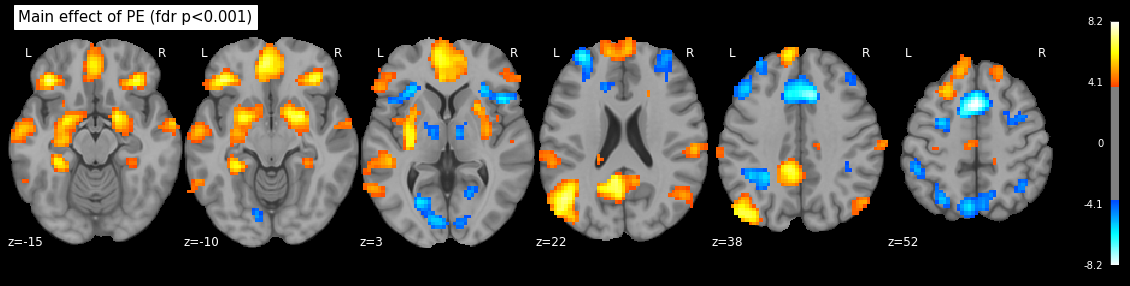

In [75]:
p_val = 0.001
height_control = 'fdr'
cut_coords = (-15, -10, 3, 22, 38, 52)
display_mode = 'z'
title = 'Main effect of PE'

################################################################################
mni152nlin2009c = "mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/"\
                  "temp.nii.gz"
bg_img = datasets.load_mni152_template()
bg_img = nib.load(mni152nlin2009c)

z_map_thresholded, threshold = map_threshold(
    z_map,
    level=p_val,
    height_control='fdr',
    cluster_threshold=15)

fig, ax = plt.subplots(ncols=1, nrows=1, facecolor='k', figsize=(20, 5))
display = plotting.plot_stat_map(
    z_map,
    bg_img=bg_img,
    axes=ax,
    threshold=threshold,
    colorbar=True,
    display_mode=display_mode,
    cut_coords=cut_coords,
    title=f'{title} ({height_control} p<{p_val})')

### Difference in PE scaling between conditions

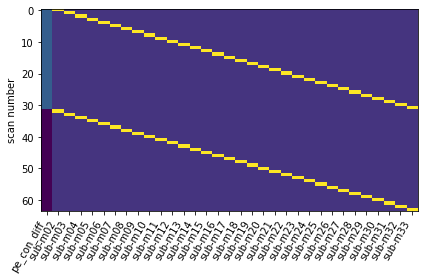

In [14]:
second_level_input = [tmap for tmaps in tmap_img for tmap in tmaps]
second_level_model = SecondLevelModel(smoothing_fwhm=6)

# Paired two-group difference for reward – punishment contrast
columns = ['pe_con_diff'] + \
          [f'sub-m{sub:02}' for sub in range(2, n_subjects+2)]
design_matrix = pd.DataFrame(np.hstack((
    np.vstack((np.ones((n_subjects, 1)), (-1)*np.ones((n_subjects, 1)))),   
    np.vstack((np.eye(n_subjects), np.eye(n_subjects)))
    )), columns=columns)

contrast = np.zeros(design_matrix.shape[1])
contrast[list(design_matrix.columns).index('pe_con_diff')] = 1

fig, ax = plt.subplots(nrows=1, ncols=1, facecolor='w')
plot_design_matrix(design_matrix, ax=ax)

second_level_model = second_level_model.fit(
    second_level_input, 
    design_matrix=design_matrix)

z_map = second_level_model.compute_contrast(
    contrast,
    output_type='z_score')

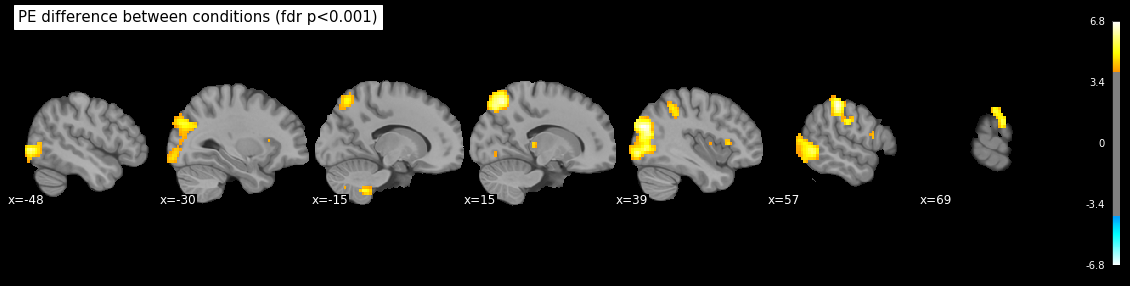

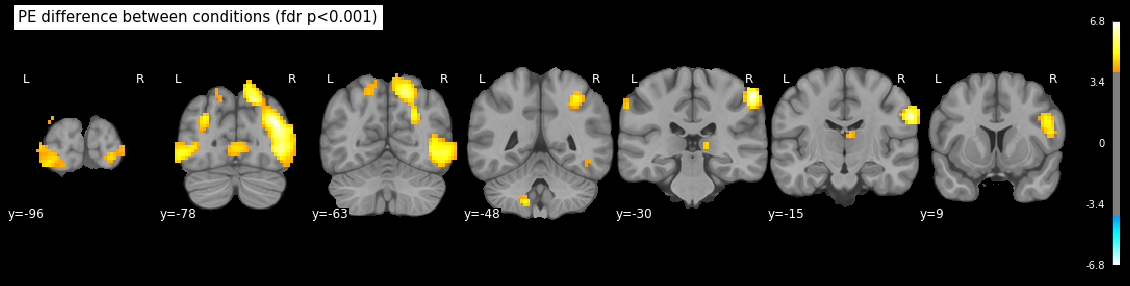

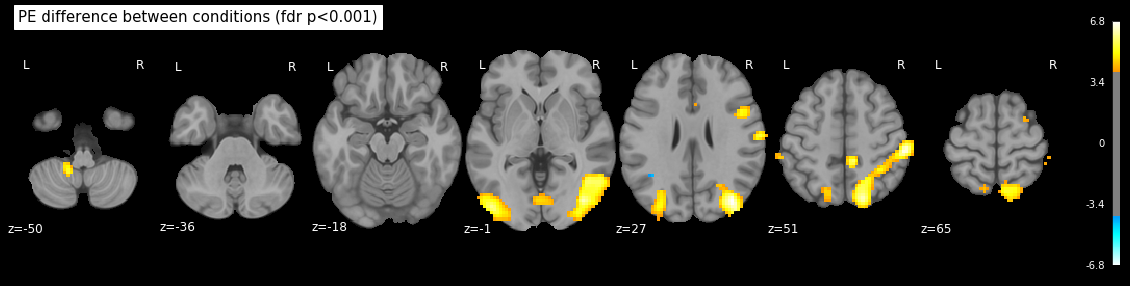

In [15]:
p_val = 0.001
height_control = 'fdr'
title = 'PE difference between conditions'

################################################################################
mni152nlin2009c = "mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/"\
                  "temp.nii.gz"
bg_img = datasets.load_mni152_template()
bg_img = nib.load(mni152nlin2009c)

z_map_thresholded, threshold = map_threshold(
    z_map,
    level=p_val,
    height_control='fdr',
    cluster_threshold=15)

for display_mode in ['x', 'y', 'z']:

    fig, ax = plt.subplots(ncols=1, nrows=1, facecolor='k', figsize=(20, 5))
    display = plotting.plot_stat_map(
        z_map,
        bg_img=bg_img,
        axes=ax,
        threshold=threshold,
        colorbar=True,
        display_mode=display_mode,
        title=f'{title} ({height_control} p<{p_val})')

### Condition-specific PE activations

In [4]:
z_maps = []

for condition in [0, 1]:
    
    second_level_input = [tmap for tmap in tmap_img[condition]]
    second_level_model = SecondLevelModel(smoothing_fwhm=8)

    # Main effect of PE for condition
    design_matrix = pd.DataFrame([1] * len(second_level_input),
                                 columns=['intercept'])

    second_level_model = second_level_model.fit(
        second_level_input, 
        design_matrix=design_matrix)

    z_maps.append(second_level_model.compute_contrast(output_type='z_score'))

/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/image/image.py:455: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  not isinstance(imgs, collections.Iterable)):
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


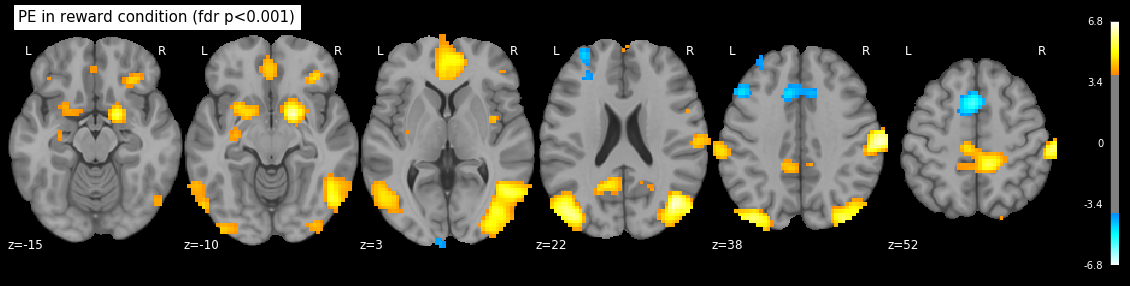

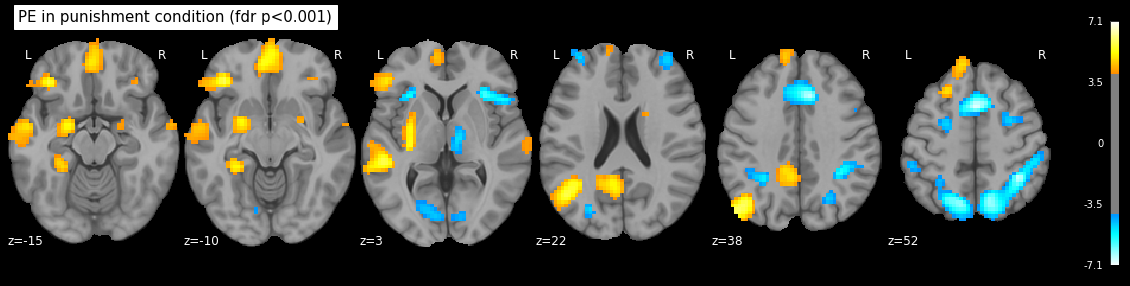

In [12]:
p_val = 0.001
height_control = 'fdr'
cut_coords = (-15, -10, 3, 22, 38, 52)
display_mode = 'z'

################################################################################
mni152nlin2009c = "mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/"\
                  "temp.nii.gz"
bg_img = datasets.load_mni152_template()
bg_img = nib.load(mni152nlin2009c)

for con, z_map in enumerate(z_maps): 
    
    if con == 0:
        title = 'PE in reward condition'
    else:
        title = 'PE in punishment condition'
    
    z_map_thresholded, threshold = map_threshold(
        z_map,
        level=p_val,
        height_control='fdr',
        cluster_threshold=15)

    fig, ax = plt.subplots(ncols=1, nrows=1, facecolor='k', figsize=(20, 5))
    display = plotting.plot_stat_map(
        z_map,
        bg_img=bg_img,
        axes=ax,
        threshold=threshold,
        colorbar=True,
        display_mode=display_mode,
        cut_coords=cut_coords,
        title=f'{title} ({height_control} p<{p_val})')

In [86]:
tb = get_clusters_table(z_map_thresholded, threshold, cluster_threshold=15, min_distance=8.0)
tb = tb.loc[tb['Cluster Size (mm3)'] != '']